In [1]:
import pyodbc
import pandas as pd
import swifter
import seaborn as sns
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
import numpy as np
import evalml
gc.collect()

3

# Load Data

In [2]:
with pyodbc.connect('DRIVER={SQL SERVER};SERVER=SAS-CI-DB1-P') as conn:
    strq = 'SELECT DISTINCT phone\
                    , CommFlag\
                    , OrderFlag\
                    , Order_Ago\
                    , min_diff\
                    , max_diff\
                    , avg_diff\
                    , avg_check\
                    , avg_mass_check\
                    , Mean_Item_Cost\
                    , sum_amount_18\
                    , cnt_amount_18\
                    , Mass_amount_18\
                    , Parfume_AMOUNT_18\
                    , Lux_Parfume_AMOUNT_18\
                    , sum_amount_3\
                    , sum_amount_6\
                    , sum_amount_9\
                    , sum_amount_12\
                    , sum_amount_15\
                    , cnt_amount_3\
                    , cnt_amount_6\
                    , cnt_amount_9\
                    , cnt_amount_12\
                    , cnt_amount_15\
                    , Mass_amount_3\
                    , Mass_amount_6\
                    , Mass_amount_9\
                    , Mass_amount_12\
                    , Mass_amount_15\
                    , Parfume_Amount_3\
                    , Parfume_Amount_6\
                    , Parfume_Amount_9\
                    , Parfume_Amount_12\
                    , Parfume_Amount_15\
                    , Lux_Parfume_Amount_3\
                    , Lux_Parfume_Amount_6\
                    , Lux_Parfume_Amount_9\
                    , Lux_Parfume_Amount_12\
                    , Lux_Parfume_Amount_15\
                    , age\
                    , LIFECYCLE_TYPE\
                    , sex \
                    FROM ##DataSet\
                    WHERE cnt_amount_18 > 0'
    df = pd.read_sql(strq, conn)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [3]:
df.dtypes

phone                     object
CommFlag                   int64
OrderFlag                  int64
Order_Ago                  int64
min_diff                 float64
max_diff                 float64
avg_diff                 float64
avg_check                float64
avg_mass_check           float64
Mean_Item_Cost           float64
sum_amount_18            float64
cnt_amount_18              int64
Mass_amount_18           float64
Parfume_AMOUNT_18        float64
Lux_Parfume_AMOUNT_18    float64
sum_amount_3             float64
sum_amount_6             float64
sum_amount_9             float64
sum_amount_12            float64
sum_amount_15            float64
cnt_amount_3               int64
cnt_amount_6               int64
cnt_amount_9               int64
cnt_amount_12              int64
cnt_amount_15              int64
Mass_amount_3            float64
Mass_amount_6            float64
Mass_amount_9            float64
Mass_amount_12           float64
Mass_amount_15           float64
Parfume_Am

In [4]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
0,70000136255,1,0,5,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,...,10307.0,10307.0,NaN,NaN,NaN,NaN,NaN,24.0,0,0.0
1,70001625391,1,0,6,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,...,15083.0,15083.0,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
2,70021067460,1,0,15,240.0,240.0,240.0,229.0000,229.00,229.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1,0.0
3,70032000019,1,0,10,NaN,NaN,NaN,2598.5000,2598.50,1299.250000,...,2149.5,2149.5,NaN,NaN,NaN,NaN,NaN,57.0,1,0.0
4,70131878044,1,0,14,1.0,35.0,17.0,955.7111,933.65,614.385714,...,NaN,4206.0,NaN,NaN,NaN,NaN,NaN,21.0,1,0.0


In [9]:
# med = df.age.median()
# df.age = df.age.swifter.apply(lambda x: x if (x > 16) and (x < 80) else med)
# df.age = df.age.fillna(med)
# df.sex = df.sex.fillna(round(df.sex.median()))
# df.Order_Ago = df.Order_Ago.fillna(36)


Dask Apply: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


In [5]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
0,70000136255,1,0,5,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,...,10307.0,10307.0,NaN,NaN,NaN,NaN,NaN,24.0,0,0.0
1,70001625391,1,0,6,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,...,15083.0,15083.0,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
2,70021067460,1,0,15,240.0,240.0,240.0,229.0000,229.00,229.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1,0.0
3,70032000019,1,0,10,NaN,NaN,NaN,2598.5000,2598.50,1299.250000,...,2149.5,2149.5,NaN,NaN,NaN,NaN,NaN,57.0,1,0.0
4,70131878044,1,0,14,1.0,35.0,17.0,955.7111,933.65,614.385714,...,NaN,4206.0,NaN,NaN,NaN,NaN,NaN,21.0,1,0.0


In [6]:
df.describe()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
count,848030.000000,848030.00000,848030.000000,731399.000000,731399.000000,731399.000000,848030.000000,820101.000000,848030.000000,8.480300e+05,...,5.100100e+05,5.491040e+05,1.912700e+04,4.607200e+04,6.983300e+04,9.572400e+04,1.124020e+05,801401.000000,848030.000000,821137.000000
mean,0.756904,0.06261,5.536977,138.477943,301.274760,205.992616,2818.653903,2510.238606,1768.026428,1.126126e+04,...,7.629662e+03,8.685284e+03,5.982303e+03,5.657979e+03,5.634988e+03,5.558762e+03,5.708032e+03,43.307657,0.915794,0.111386
std,0.428953,0.24226,3.870152,198.884617,179.938566,178.456342,2407.374612,2168.477299,1871.147462,6.247594e+04,...,3.784145e+04,4.782720e+04,1.511939e+04,1.449019e+04,1.490326e+04,1.542584e+04,1.677240e+04,11.862788,0.277696,0.314609
min,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,-1424.875000,-1424.875000,-0.500000,-2.849750e+03,...,-1.677625e+04,-1.031325e+04,-9.900000e+03,-1.192500e+04,-1.192500e+04,-2.250000e+04,-1.192500e+04,13.000000,0.000000,0.000000
25%,1.000000,0.00000,2.000000,9.000000,173.000000,83.000000,1298.646250,1033.775000,599.850000,2.969000e+03,...,2.949500e+03,3.114300e+03,1.999500e+03,1.994300e+03,1.924500e+03,1.837500e+03,1.836750e+03,35.000000,1.000000,0.000000
50%,1.000000,0.00000,5.000000,44.000000,265.000000,145.000000,2302.350000,2024.125000,1229.400000,6.372275e+03,...,4.875000e+03,5.385000e+03,3.099500e+03,3.099500e+03,3.008600e+03,2.949500e+03,2.949500e+03,42.000000,1.000000,0.000000
75%,1.000000,0.00000,8.000000,182.000000,386.000000,268.000000,3674.854950,3389.070000,2275.072917,1.278755e+04,...,8.594400e+03,9.735000e+03,6.038950e+03,5.774300e+03,5.774300e+03,5.739300e+03,5.811750e+03,51.000000,1.000000,0.000000
max,1.000000,1.00000,18.000000,1168.000000,1168.000000,1168.000000,505250.000000,505250.000000,54465.100000,1.200998e+07,...,4.863092e+06,5.792420e+06,1.550702e+06,1.984067e+06,1.984067e+06,1.984067e+06,1.984067e+06,93.000000,1.000000,1.000000


In [7]:
df.to_csv('DataSetUpLif.csv', index = False, sep = ';')

In [8]:
print('Median age ', med)

NameError: name 'med' is not defined

In [9]:
del df

# EDA

In [2]:
df = pd.read_csv('DataSetUpLif.csv', sep = ';', dtype={'phone':'str'})

In [3]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
0,70000136255,1,0,5,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,...,10307.0,10307.0,NaN,NaN,NaN,NaN,NaN,24.0,0,0.0
1,70001625391,1,0,6,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,...,15083.0,15083.0,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
2,70021067460,1,0,15,240.0,240.0,240.0,229.0000,229.00,229.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1,0.0
3,70032000019,1,0,10,NaN,NaN,NaN,2598.5000,2598.50,1299.250000,...,2149.5,2149.5,NaN,NaN,NaN,NaN,NaN,57.0,1,0.0
4,70131878044,1,0,14,1.0,35.0,17.0,955.7111,933.65,614.385714,...,NaN,4206.0,NaN,NaN,NaN,NaN,NaN,21.0,1,0.0


In [4]:
df.dtypes

phone                     object
CommFlag                   int64
OrderFlag                  int64
Order_Ago                  int64
min_diff                 float64
max_diff                 float64
avg_diff                 float64
avg_check                float64
avg_mass_check           float64
Mean_Item_Cost           float64
sum_amount_18            float64
cnt_amount_18              int64
Mass_amount_18           float64
Parfume_AMOUNT_18        float64
Lux_Parfume_AMOUNT_18    float64
sum_amount_3             float64
sum_amount_6             float64
sum_amount_9             float64
sum_amount_12            float64
sum_amount_15            float64
cnt_amount_3               int64
cnt_amount_6               int64
cnt_amount_9               int64
cnt_amount_12              int64
cnt_amount_15              int64
Mass_amount_3            float64
Mass_amount_6            float64
Mass_amount_9            float64
Mass_amount_12           float64
Mass_amount_15           float64
Parfume_Am

In [5]:
df = df.set_index('phone')
df.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000136255,1,0,5,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,23741.0,...,10307.0,10307.0,NaN,NaN,NaN,NaN,NaN,24.0,0,0.0
70001625391,1,0,6,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,15137.5,...,15083.0,15083.0,NaN,NaN,NaN,NaN,NaN,38.0,1,1.0
70021067460,1,0,15,240.0,240.0,240.0,229.0000,229.00,229.000000,458.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1,0.0
70032000019,1,0,10,NaN,NaN,NaN,2598.5000,2598.50,1299.250000,2598.5,...,2149.5,2149.5,NaN,NaN,NaN,NaN,NaN,57.0,1,0.0
70131878044,1,0,14,1.0,35.0,17.0,955.7111,933.65,614.385714,8601.4,...,NaN,4206.0,NaN,NaN,NaN,NaN,NaN,21.0,1,0.0


In [6]:
any(df.isna())

True

In [7]:
df.iloc[:, 3:-3] = df.iloc[:, 3:-3].fillna(0)

In [8]:
df.iloc[:, 3:-3].head()

,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,Parfume_AMOUNT_18,...,Parfume_Amount_3,Parfume_Amount_6,Parfume_Amount_9,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15
phone,,,,,,,,,,,,,,,,,,,,,
70000136255,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,23741.0,9,15715.0,10307.0,...,0.0,10307.0,10307.0,10307.0,10307.0,0.0,0.0,0.0,0.0,0.0
70001625391,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,15137.5,2,15132.5,15083.0,...,0.0,0.0,4973.5,15083.0,15083.0,0.0,0.0,0.0,0.0,0.0
70021067460,240.0,240.0,240.0,229.0000,229.00,229.000000,458.0,2,458.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70032000019,0.0,0.0,0.0,2598.5000,2598.50,1299.250000,2598.5,1,2598.5,2149.5,...,0.0,0.0,0.0,2149.5,2149.5,0.0,0.0,0.0,0.0,0.0
70131878044,1.0,35.0,17.0,955.7111,933.65,614.385714,8601.4,9,5601.9,4206.0,...,0.0,0.0,0.0,0.0,4206.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000136255,1,0,5,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,23741.0,...,10307.0,10307.0,0.0,0.0,0.0,0.0,0.0,24.0,0,0.0
70001625391,1,0,6,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,15137.5,...,15083.0,15083.0,0.0,0.0,0.0,0.0,0.0,38.0,1,1.0
70021067460,1,0,15,240.0,240.0,240.0,229.0000,229.00,229.000000,458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1,0.0
70032000019,1,0,10,0.0,0.0,0.0,2598.5000,2598.50,1299.250000,2598.5,...,2149.5,2149.5,0.0,0.0,0.0,0.0,0.0,57.0,1,0.0
70131878044,1,0,14,1.0,35.0,17.0,955.7111,933.65,614.385714,8601.4,...,0.0,4206.0,0.0,0.0,0.0,0.0,0.0,21.0,1,0.0


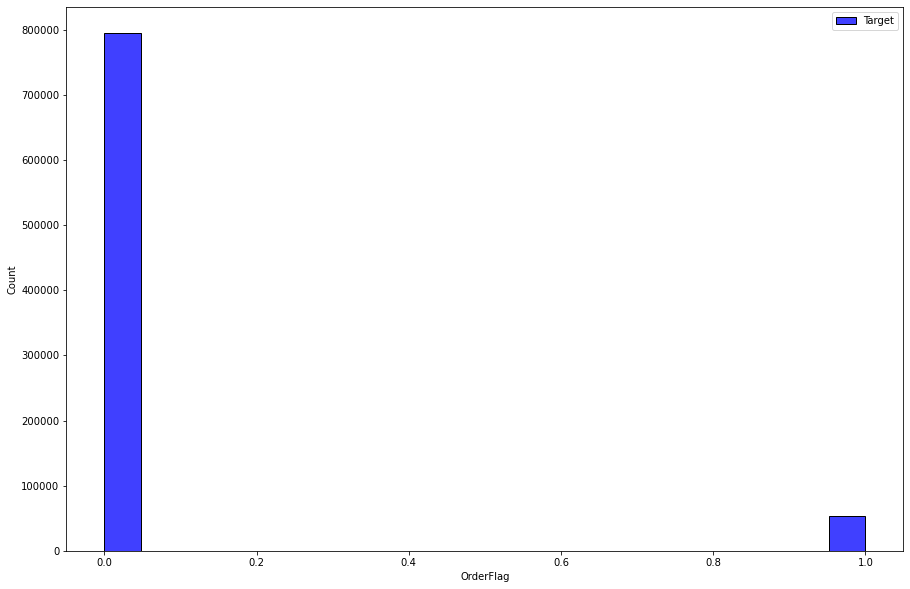

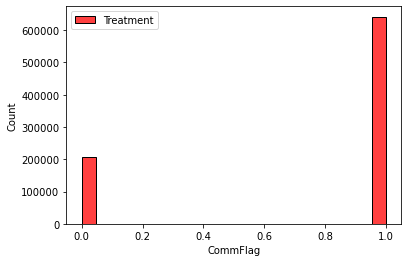

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(df.OrderFlag, label = 'Target', color = 'blue')
plt.legend()
plt.show()

sns.histplot(df.CommFlag, label = 'Treatment', color = 'red')
plt.legend()
plt.show()

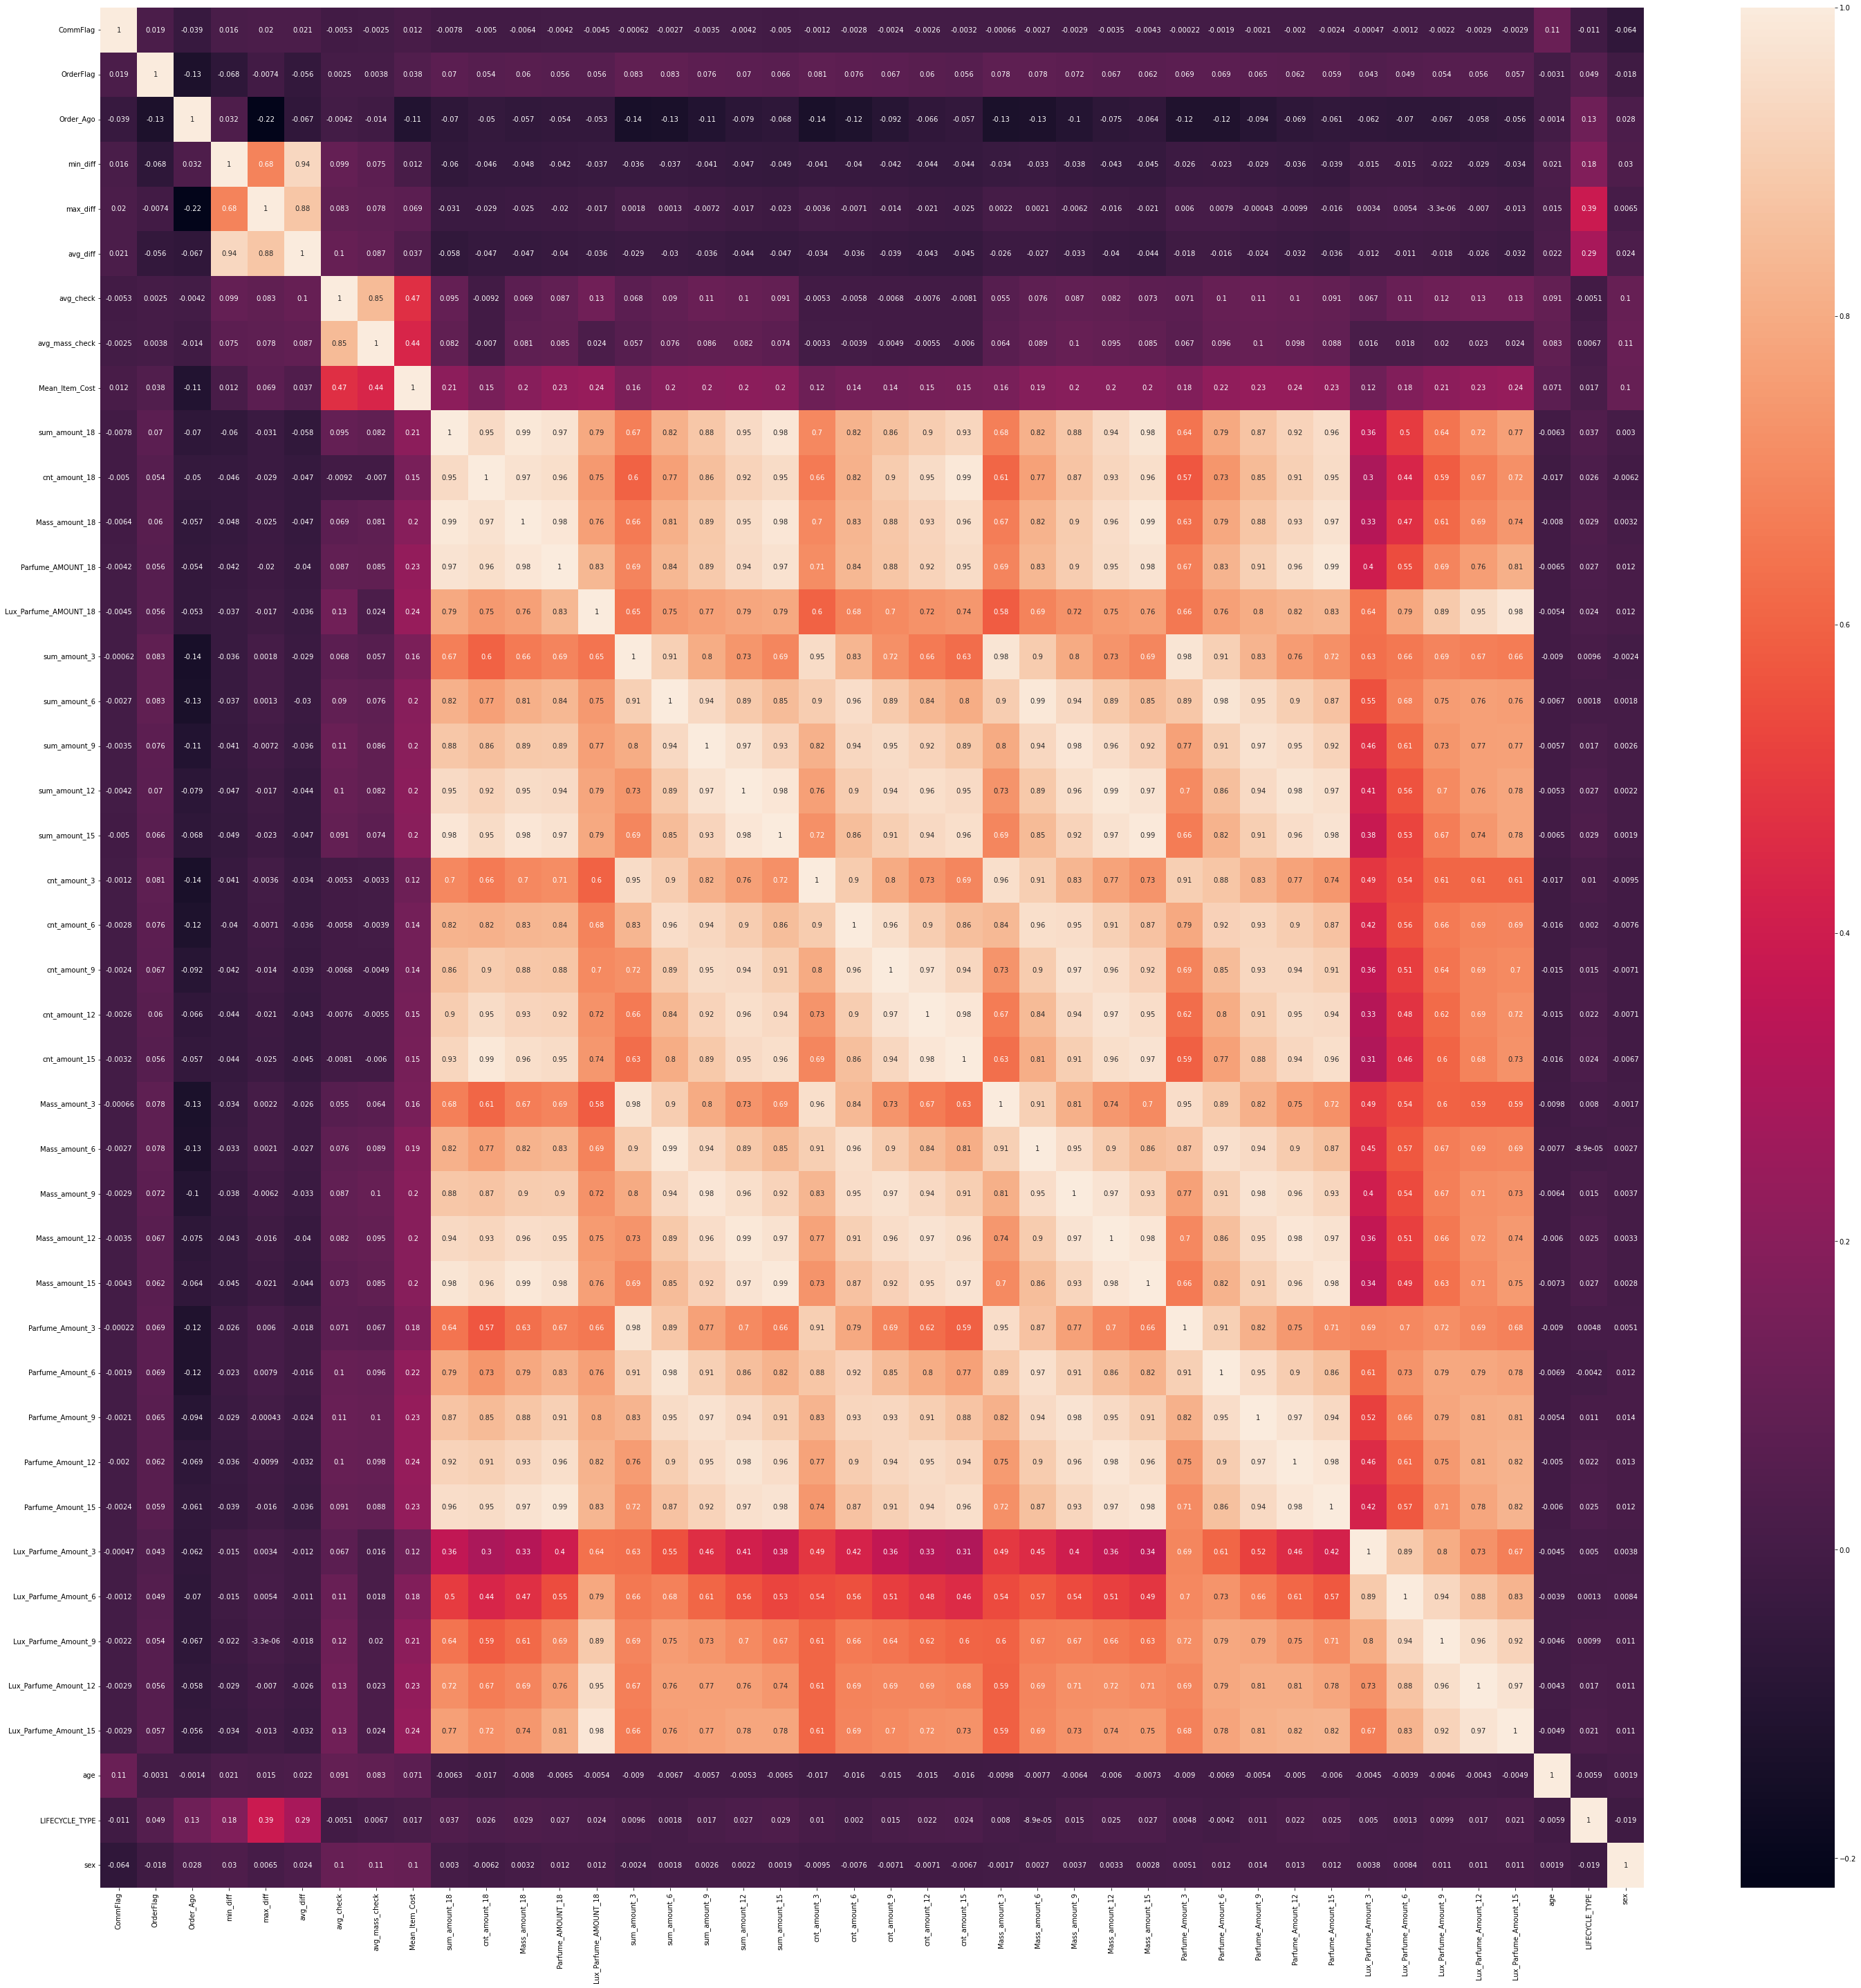

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (50, 50))
corr_matrix = df.corr()

#Using heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, ax = ax)
del corr_matrix

In [12]:
df.iloc[:, 2:].head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
70000136255,5,3.0,9.0,6.0,2637.8888,2245.00,1582.733333,23741.0,9,15715.0,...,10307.0,10307.0,0.0,0.0,0.0,0.0,0.0,24.0,0,0.0
70001625391,6,141.0,369.0,255.0,7568.7500,7566.25,2522.916667,15137.5,2,15132.5,...,15083.0,15083.0,0.0,0.0,0.0,0.0,0.0,38.0,1,1.0
70021067460,15,240.0,240.0,240.0,229.0000,229.00,229.000000,458.0,2,458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1,0.0
70032000019,10,0.0,0.0,0.0,2598.5000,2598.50,1299.250000,2598.5,1,2598.5,...,2149.5,2149.5,0.0,0.0,0.0,0.0,0.0,57.0,1,0.0
70131878044,14,1.0,35.0,17.0,955.7111,933.65,614.385714,8601.4,9,5601.9,...,0.0,4206.0,0.0,0.0,0.0,0.0,0.0,21.0,1,0.0


In [13]:
X = df.iloc[:, 2:].values
features = df.iloc[:, 2:].columns.to_list()
y = df.iloc[:, 0:2]
p = round(y[y.CommFlag == 1].shape[0] / y.shape[0], 1) #0.5
Z = y.OrderFlag * (y.CommFlag - p) / (p * (1-p)) 
Z.head()

phone
70000136255    0.0
70001625391    0.0
70021067460    0.0
70032000019    0.0
70131878044    0.0
dtype: float64

In [14]:
p

0.2

In [15]:
del df
del y
gc.collect()

0

In [16]:
#X.head()

In [17]:
Z.describe()

count    848030.000000
mean          0.230328
std           1.096354
min          -1.250000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
dtype: float64

In [18]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# scaler = StandardScaler()
# X = scaler.fit_transform(imp_mean.fit_transform(X))
# pd.isna(X).any()


In [32]:
gc.collect()
del X_test
del X_train
del y_test
del y_train
del automl

NameError: name 'X_test' is not defined

In [19]:
gc.collect()

0

In [20]:
from evalml import AutoMLSearch

In [21]:
#X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, y,problem_type='binary')
X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, Z,problem_type='regression')

In [22]:
del X
del Z
gc.collect()
gc.enable()

In [23]:
# automl=AutoMLSearch(X_train = X_train
#                     , y_train = y_train
#                     , n_jobs = -1
#                     , problem_type='binary'
#                     , verbose = True
#                     # , max_batches = 1
#                     # , optimize_thresholds=True
#                     # , ensembling=True
#                     # , max_iterations = 10
#                     #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
#                     )

# automl=AutoMLSearch(X_train = X_train
#                     , y_train = y_train
#                     , n_jobs = -1
#                     , problem_type='regression'
#                     , verbose = True
#                      , objective = 'mse'
#                     # , optimize_thresholds=True
#                     # , ensembling=True
#                     # , max_iterations = 10
#                     #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
#                     )


automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 10
                    , objective = 'Root Mean Squared Error'
                    , optimize_thresholds=True
                    , ensembling=True
                    , max_iterations = 20
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Root Mean Squared Error. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 10 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.097


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 1 *
*****************************



C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.190e+04, tolerance: 2.040e+01



Elastic Net Regressor w/ Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.088


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.077


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 2 *
*****************************



C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.979e+04, tolerance: 2.040e+01



Elastic Net Regressor w/ Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.097


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.078


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.082


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.080


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



XGBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.080

*****************************
* Evaluating Batch Number 4 *
*****************************



C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Stacked Ensemble Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.112


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 5 *
*****************************

Random Forest Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.079


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.088


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



XGBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.306


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.078


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.090


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



XGBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.100


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.092


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.091


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



XGBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.208


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.092


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.079

Search finished after 22:23            


C:\Users\fejzullin\Anaconda3\envs\UpLift\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Best pipeline: Random Forest Regressor w/ Imputer
Best pipeline Root Mean Squared Error: 1.076754


In [32]:
automl.rankings

NameError: name 'automl' is not defined

In [25]:
automl.save('automl_big_searching.cloudpickle')

In [26]:
best = automl.best_pipeline
print(best.parameters)


{'Imputer': {'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Random Forest Regressor': {'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}}


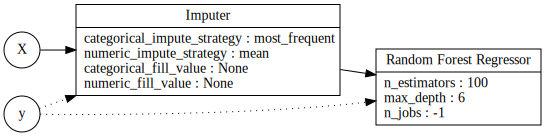

In [27]:
best.graph()

In [28]:
best.save('best_XGBoos.cloudpickle')

In [29]:
zipped = list(zip(features, np.round(np.array(best.estimator._component_obj.feature_importances_) * 100, 2)))
sort_zip = sorted(zipped, key = lambda x: x[1], reverse = True)
print(sort_zip)

[('cnt_amount_12', 47.49), ('cnt_amount_15', 22.31), ('cnt_amount_3', 4.85), ('sum_amount_3', 4.74), ('cnt_amount_18', 2.77), ('Order_Ago', 2.72), ('age', 2.45), ('avg_diff', 2.41), ('sum_amount_6', 1.68), ('sum_amount_9', 1.4), ('max_diff', 1.2), ('sum_amount_12', 1.08), ('sum_amount_18', 0.67), ('cnt_amount_6', 0.52), ('Mean_Item_Cost', 0.48), ('sum_amount_15', 0.38), ('Mass_amount_3', 0.32), ('Mass_amount_12', 0.28), ('min_diff', 0.26), ('Mass_amount_18', 0.2), ('Mass_amount_6', 0.18), ('cnt_amount_9', 0.17), ('Mass_amount_9', 0.15), ('avg_check', 0.14), ('avg_mass_check', 0.12), ('Mass_amount_15', 0.12), ('Parfume_Amount_9', 0.11), ('Lux_Parfume_Amount_12', 0.11), ('Parfume_AMOUNT_18', 0.1), ('Lux_Parfume_AMOUNT_18', 0.08), ('Parfume_Amount_3', 0.07), ('Lux_Parfume_Amount_6', 0.07), ('Lux_Parfume_Amount_9', 0.07), ('Parfume_Amount_6', 0.06), ('Parfume_Amount_12', 0.06), ('Parfume_Amount_15', 0.06), ('Lux_Parfume_Amount_3', 0.04), ('Lux_Parfume_Amount_15', 0.03), ('sex', 0.03), ('LI

In [30]:
scores = best.score(X_test, y_test,  objectives=evalml.objectives.get_core_objectives('regression'))
print(scores)

OrderedDict([('ExpVariance', 0.036265113457939036), ('MaxError', 5.371386114427402), ('MedianAE', 0.17857662506773528), ('MSE', 1.1539180178236002), ('MAE', 0.45083064344473356), ('R2', 0.036264912695317175), ('Root Mean Squared Error', 1.0742057613993699)])


In [31]:

del X_test
del X_train
del y_test
del y_train
del automl
gc.collect()

142

# AutoML Search Analyz

In [32]:
from sklift.metrics import uplift_at_k

In [2]:
automl2 = evalml.automl.AutoMLSearch.load("automl_big_searching.cloudpickle")

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant


In [3]:
automl2.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,2,Random Forest Regressor w/ Imputer,2,NaN,NaN,1.076754,1.840582,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,4,Random Forest Regressor w/ Imputer + RF Regres...,4,NaN,NaN,1.078025,1.724648,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,12,Random Forest Regressor w/ Imputer + Select Co...,12,NaN,NaN,1.078111,1.716814,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,19,Extra Trees Regressor w/ Imputer + Select Colu...,19,NaN,NaN,1.078973,1.638218,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,7,XGBoost Regressor w/ Imputer + Select Columns ...,7,NaN,NaN,1.080034,1.541553,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,5,Decision Tree Regressor w/ Imputer + Select Co...,5,NaN,NaN,1.081950,1.366851,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,1,Elastic Net Regressor w/ Imputer + Standard Sc...,1,NaN,NaN,1.087543,0.857018,False,{'Imputer': {'categorical_impute_strategy': 'm...
14,3,Elastic Net Regressor w/ Imputer + Standard Sc...,3,NaN,NaN,1.096907,0.003361,False,{'Imputer': {'categorical_impute_strategy': 'm...
15,0,Mean Baseline Regression Pipeline,0,NaN,NaN,1.096944,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}
17,8,Stacked Ensemble Regression Pipeline,8,NaN,NaN,1.112341,-1.403686,False,{'Linear Pipeline - Imputer': {'categorical_im...


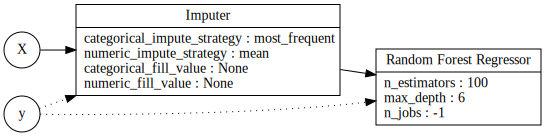

In [4]:
best = automl2.best_pipeline
best.graph()

In [5]:
#Submission
subm = pd.read_csv('ControlSet.csv', sep = ';',dtype={'phone':'str', 'Order_Ago':'float64'})
subm = subm.set_index('phone')
subm.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
79000000911,0,0,2.0,NaN,NaN,NaN,5471.0000,5471.00,5471.000000,5471.00,...,5471.0,5471.00,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
79000001507,1,0,3.0,NaN,NaN,NaN,893.0000,893.00,893.000000,893.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,1,0.0
79000002803,0,0,12.0,43.0,43.0,43.0,4073.0833,4069.75,6109.625000,12219.25,...,6923.0,12209.25,NaN,NaN,NaN,NaN,NaN,30.0,1,1.0
79000002888,0,0,4.0,NaN,NaN,NaN,5233.0000,5233.00,2616.500000,5233.00,...,4784.0,4784.00,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
79000003036,0,0,6.0,137.0,137.0,137.0,2909.0000,2905.50,646.444444,5818.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,1,1.0


In [6]:
subm.iloc[:, 3:-3] = subm.iloc[:, 3:-3].fillna(0)
subm.head()

,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
phone,,,,,,,,,,,,,,,,,,,,,
79000000911,0,0,2.0,0.0,0.0,0.0,5471.0000,5471.00,5471.000000,5471.00,...,5471.0,5471.00,0.0,0.0,0.0,0.0,0.0,NaN,0,1.0
79000001507,1,0,3.0,0.0,0.0,0.0,893.0000,893.00,893.000000,893.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,41.0,1,0.0
79000002803,0,0,12.0,43.0,43.0,43.0,4073.0833,4069.75,6109.625000,12219.25,...,6923.0,12209.25,0.0,0.0,0.0,0.0,0.0,30.0,1,1.0
79000002888,0,0,4.0,0.0,0.0,0.0,5233.0000,5233.00,2616.500000,5233.00,...,4784.0,4784.00,0.0,0.0,0.0,0.0,0.0,NaN,1,0.0
79000003036,0,0,6.0,137.0,137.0,137.0,2909.0000,2905.50,646.444444,5818.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,39.0,1,1.0


In [7]:
X_ = subm.iloc[:, 2:].values
X_val = subm.iloc[:, 2:]
Y_val = subm.iloc[:, [0, 1]]

In [8]:
Y_val.head()

,CommFlag,OrderFlag
phone,,
79000000911,0,0
79000001507,1,0
79000002803,0,0
79000002888,0,0
79000003036,0,0


In [9]:
Y_val_subm = Y_val[(Y_val['CommFlag'] == 1) & (Y_val['OrderFlag'] == 1)]
Y_val[(Y_val['CommFlag'] == 1) & (Y_val['OrderFlag'] == 1)].shape[0]

19896

In [10]:
# X_val['CommFlag'] = 1
# y_pred_1 = best.predict_proba(X_val)
# y_pred_1 = y_pred_1[1]
# y_pred_1.head()

#Class Transform
#X_val['CommFlag'] = 1
y_pred_1 = best.predict(X_)
#y_pred_1 = y_pred_1[1]
y_pred_1.head()

0    0.094388
1    0.098758
2    0.115848
3    0.085451
4    0.137016
dtype: float64

In [11]:
y_pred_1.shape

(1364123,)

In [12]:
X_val['UpLift'] = y_pred_1.tolist()

In [13]:
X_val.head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex,UpLift
phone,,,,,,,,,,,,,,,,,,,,,
79000000911,2.0,0.0,0.0,0.0,5471.0000,5471.00,5471.000000,5471.00,1,5471.00,...,5471.00,0.0,0.0,0.0,0.0,0.0,NaN,0,1.0,0.094388
79000001507,3.0,0.0,0.0,0.0,893.0000,893.00,893.000000,893.00,1,893.00,...,0.00,0.0,0.0,0.0,0.0,0.0,41.0,1,0.0,0.098758
79000002803,12.0,43.0,43.0,43.0,4073.0833,4069.75,6109.625000,12219.25,3,12209.25,...,12209.25,0.0,0.0,0.0,0.0,0.0,30.0,1,1.0,0.115848
79000002888,4.0,0.0,0.0,0.0,5233.0000,5233.00,2616.500000,5233.00,1,5233.00,...,4784.00,0.0,0.0,0.0,0.0,0.0,NaN,1,0.0,0.085451
79000003036,6.0,137.0,137.0,137.0,2909.0000,2905.50,646.444444,5818.00,2,5811.00,...,0.00,0.0,0.0,0.0,0.0,0.0,39.0,1,1.0,0.137016


In [14]:
print(X_.shape)
print(X_val.shape)

(1364123, 40)
(1364123, 41)


In [15]:
X_val_metric = X_val.merge(Y_val, on = 'phone')
print(X_val_metric.shape)
X_val_metric.head()


(1364123, 43)


,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex,UpLift,CommFlag,OrderFlag
phone,,,,,,,,,,,,,,,,,,,,,
79000000911,2.0,0.0,0.0,0.0,5471.0000,5471.00,5471.000000,5471.00,1,5471.00,...,0.0,0.0,0.0,0.0,NaN,0,1.0,0.094388,0,0
79000001507,3.0,0.0,0.0,0.0,893.0000,893.00,893.000000,893.00,1,893.00,...,0.0,0.0,0.0,0.0,41.0,1,0.0,0.098758,1,0
79000002803,12.0,43.0,43.0,43.0,4073.0833,4069.75,6109.625000,12219.25,3,12209.25,...,0.0,0.0,0.0,0.0,30.0,1,1.0,0.115848,0,0
79000002888,4.0,0.0,0.0,0.0,5233.0000,5233.00,2616.500000,5233.00,1,5233.00,...,0.0,0.0,0.0,0.0,NaN,1,0.0,0.085451,0,0
79000003036,6.0,137.0,137.0,137.0,2909.0000,2905.50,646.444444,5818.00,2,5811.00,...,0.0,0.0,0.0,0.0,39.0,1,1.0,0.137016,0,0


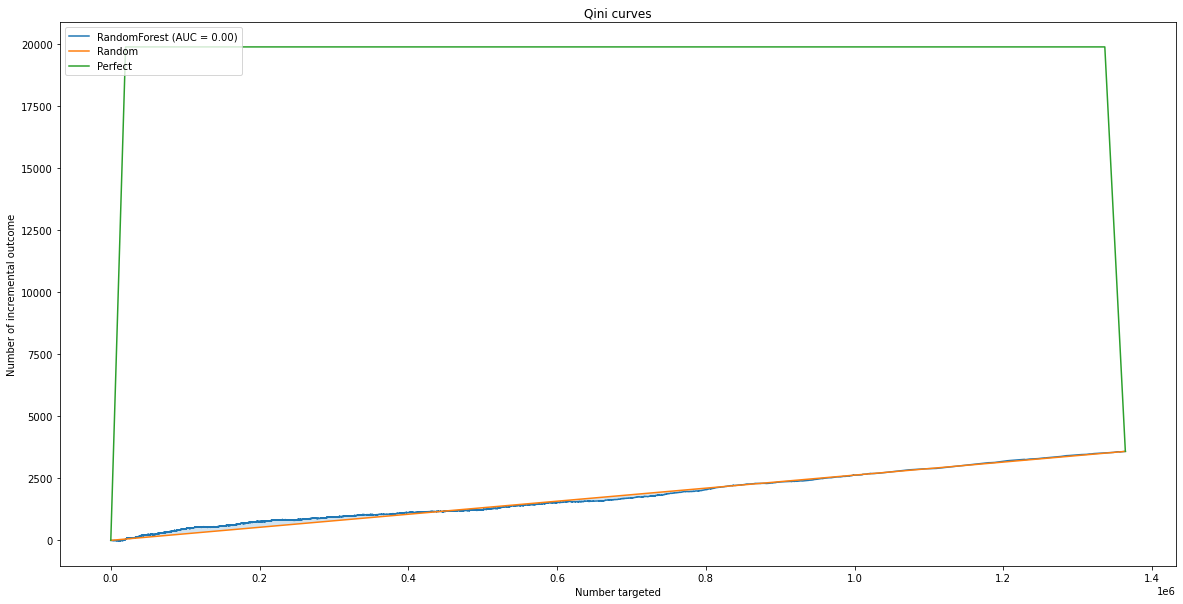

In [16]:
from sklift.viz import plot_qini_curve, plot_uplift_curve
import matplotlib.pyplot as plt
 
%matplotlib inline 
 
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_title('Qini curves')

plot_qini_curve(X_val_metric.OrderFlag.values, X_val_metric.UpLift.values, X_val_metric.CommFlag.values,
    perfect=True, name='RandomForest', ax=ax
);
ax.legend(loc = 2)
plt.savefig('qini.png')


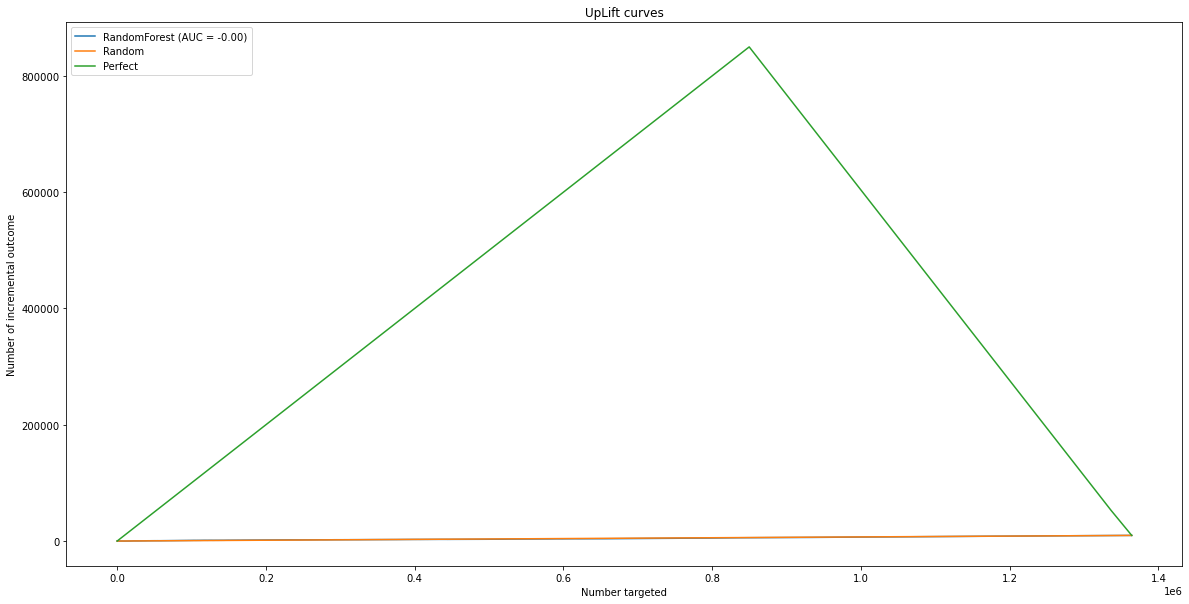

In [17]:
%matplotlib inline 
 
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_title('UpLift curves')

plot_uplift_curve(X_val_metric.OrderFlag.values, X_val_metric.UpLift.values, X_val_metric.CommFlag.values,
    perfect=True, name='RandomForest', ax=ax
);
ax.legend(loc = 2)
plt.savefig('UpLift.png')

In [48]:
h = 0.05
T = int(1 / h)
s = 0.1
cr = []
ac = []
part = []
for i in range(0, T):
    X_val_subm_i = X_val.sort_values('UpLift', ascending= False).iloc[0: round(X_val.shape[0] * s), :].merge(Y_val[Y_val['CommFlag'] == 1], on = 'phone', suffixes=('', '_y'))
    X_val_subm_i = X_val_subm_i.merge(Y_val_subm, how='left', on = 'phone', suffixes=('', '_y'))
    cr.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / X_val_subm_i.shape[0])
    ac.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / Y_val_subm.shape[0])
    part.append(s)
    del X_val_subm_i
    gc.collect()
    s += h

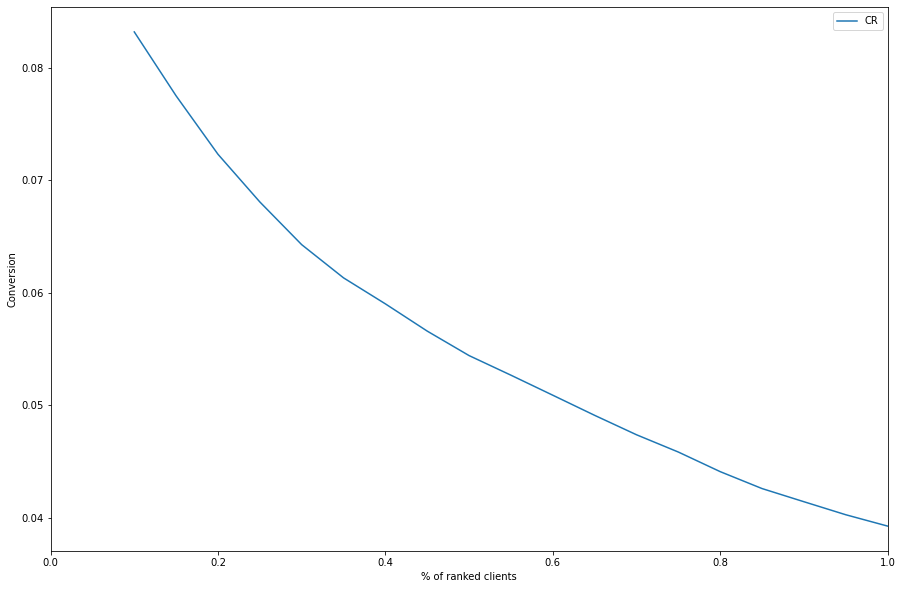

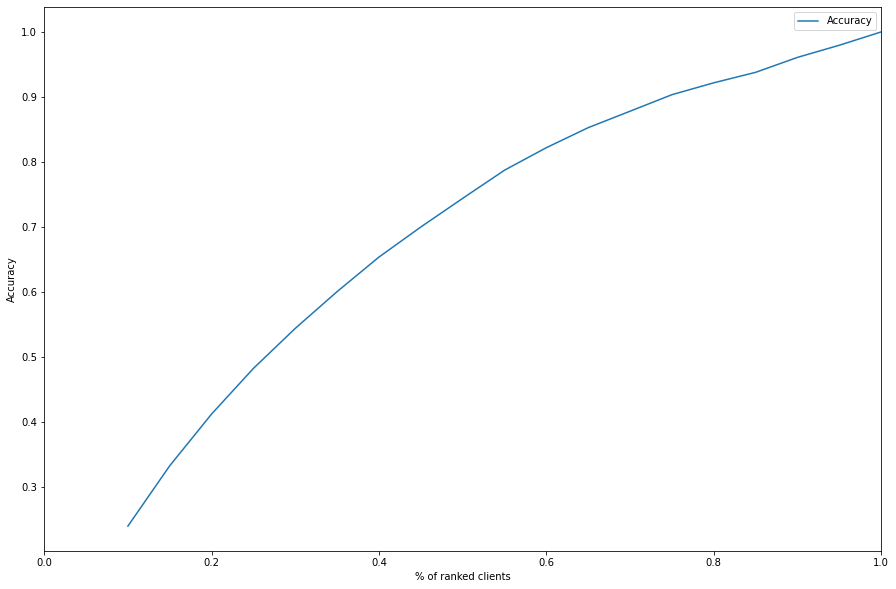

In [49]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, cr, label = 'CR')
plt.legend()
plt.xlabel('% of ranked clients')
plt.ylabel('Conversion')

plt.xlim(0, 1)
plt.show()

%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, ac, label = 'Accuracy')

plt.xlim(0, 1)
plt.xlabel('% of ranked clients')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
pd.DataFrame({'CR':cr, 'Part':part})

,CR,Part
0,0.083183,0.10
1,0.077499,0.15
2,0.072312,0.20
3,0.068076,0.25
4,0.064281,0.30
5,0.061330,0.35
6,0.059020,0.40
7,0.056598,0.45
8,0.054423,0.50
9,0.052682,0.55


In [58]:
 X_val.sort_values('UpLift', ascending= False).iloc[0: round(X_val.shape[0] * s), :].merge(Y_val[Y_val['CommFlag'] == 1], on = 'phone', suffixes=('', '_y')).shape

(506975, 43)

In [30]:
X_val_subm.head()

,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,sum_amount_18,cnt_amount_18,Mass_amount_18,...,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex,CommFlag_x,OrderFlag_x,CommFlag_y,OrderFlag_y
phone,,,,,,,,,,,,,,,,,,,,,
79000000911,2.0,0.0,0.0,0.0,5471.0000,5471.00,5471.000000,5471.00,1,5471.00,...,0.0,0.0,0.0,NaN,0,1.0,NaN,NaN,NaN,NaN
79000001507,3.0,0.0,0.0,0.0,893.0000,893.00,893.000000,893.00,1,893.00,...,0.0,0.0,0.0,41.0,1,0.0,NaN,NaN,NaN,NaN
79000002803,12.0,43.0,43.0,43.0,4073.0833,4069.75,6109.625000,12219.25,3,12209.25,...,0.0,0.0,0.0,30.0,1,1.0,NaN,NaN,NaN,NaN
79000002888,4.0,0.0,0.0,0.0,5233.0000,5233.00,2616.500000,5233.00,1,5233.00,...,0.0,0.0,0.0,NaN,1,0.0,NaN,NaN,NaN,NaN
79000003036,6.0,137.0,137.0,137.0,2909.0000,2905.50,646.444444,5818.00,2,5811.00,...,0.0,0.0,0.0,39.0,1,1.0,NaN,NaN,NaN,NaN


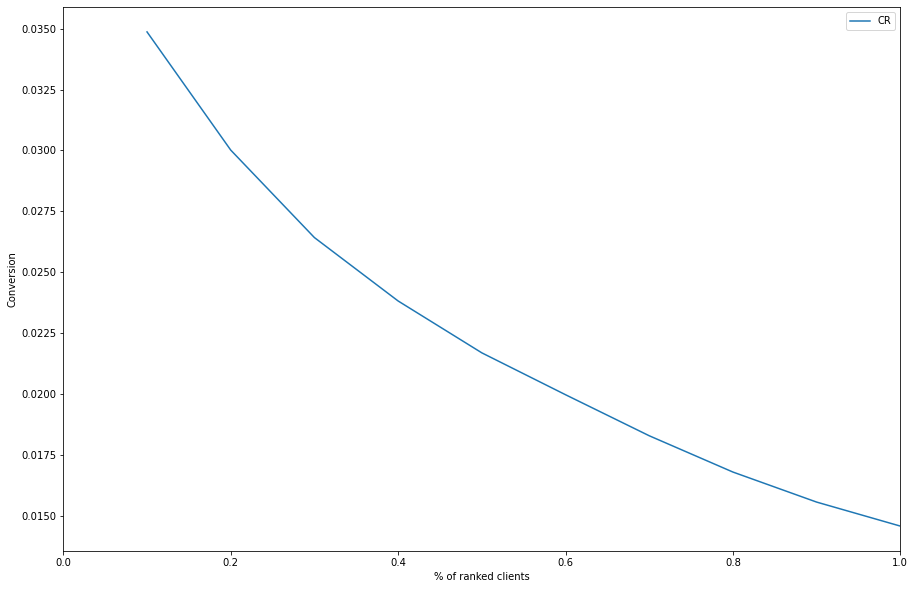

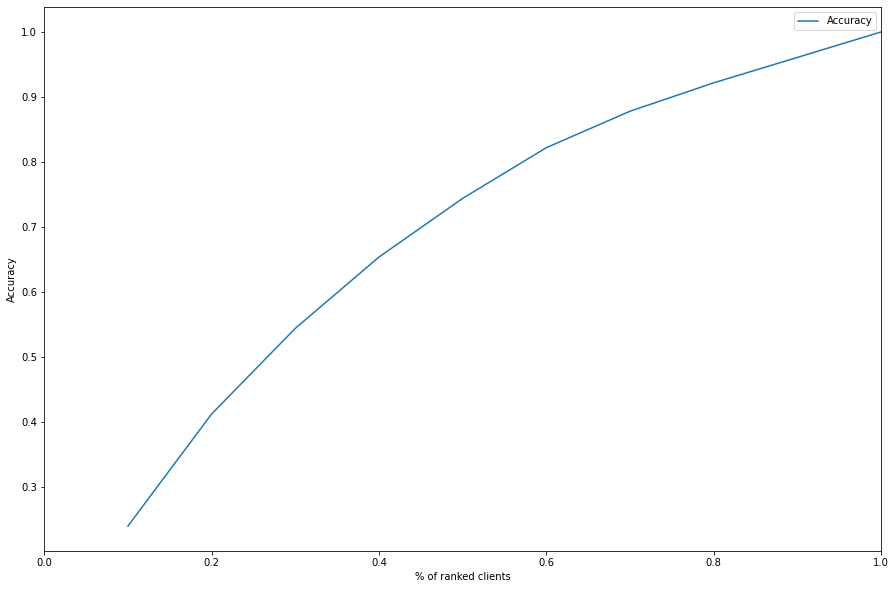

In [51]:
h = 0.1
s = 0.1
cr = []
ac = []
part = []
for i in range(0, 10):
    X_val_subm_i = X_val.sort_values('UpLift', ascending= False).iloc[0: round(X_val.shape[0] * s), :]
    X_val_subm_i = X_val_subm_i.merge(Y_val_subm, how='left', on = 'phone', suffixes=('', '_y'))
    cr.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / X_val_subm_i.shape[0])
    ac.append(X_val_subm_i[X_val_subm_i.OrderFlag == 1].shape[0] / Y_val_subm.shape[0])
    part.append(s)
    del X_val_subm_i
    gc.collect()
    s += h
    
    
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, cr, label = 'CR')
plt.legend()
plt.xlabel('% of ranked clients')
plt.ylabel('Conversion')

plt.xlim(0, 1)
plt.show()

%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(part, ac, label = 'Accuracy')

plt.xlim(0, 1)
plt.xlabel('% of ranked clients')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
pd.DataFrame({'CR':cr, 'Part':part})

,CR,Part
0,0.136361,0.1
1,0.097872,0.2
2,0.078931,0.3
3,0.068516,0.4
4,0.060734,0.5
5,0.054218,0.6
6,0.048734,0.7
7,0.043914,0.8
8,0.039896,0.9
9,0.036616,1.0


In [79]:
del subm
del X_val
del Y_val
del X_val_subm
del Y_val_subm

NameError: name 'subm' is not defined

In [80]:
gc.collect()

8337

# Load Submission

In [7]:
with pyodbc.connect('DRIVER={SQL SERVER};SERVER=SAS-CI-DB1-P;') as conn:
    strq = 'SELECT DISTINCT phone\
                    , CommFlag\
                    , OrderFlag\
                    , Order_Ago\
                    , min_diff\
                    , max_diff\
                    , avg_diff\
                    , avg_check\
                    , avg_mass_check\
                    , Mean_Item_Cost\
                    , sum_amount_18\
                    , cnt_amount_18\
                    , Mass_amount_18\
                    , Parfume_AMOUNT_18\
                    , Lux_Parfume_AMOUNT_18\
                    , sum_amount_3\
                    , sum_amount_6\
                    , sum_amount_9\
                    , sum_amount_12\
                    , sum_amount_15\
                    , cnt_amount_3\
                    , cnt_amount_6\
                    , cnt_amount_9\
                    , cnt_amount_12\
                    , cnt_amount_15\
                    , Mass_amount_3\
                    , Mass_amount_6\
                    , Mass_amount_9\
                    , Mass_amount_12\
                    , Mass_amount_15\
                    , Parfume_Amount_3\
                    , Parfume_Amount_6\
                    , Parfume_Amount_9\
                    , Parfume_Amount_12\
                    , Parfume_Amount_15\
                    , Lux_Parfume_Amount_3\
                    , Lux_Parfume_Amount_6\
                    , Lux_Parfume_Amount_9\
                    , Lux_Parfume_Amount_12\
                    , Lux_Parfume_Amount_15\
                    , age\
                    , LIFECYCLE_TYPE\
                    , sex \
                    FROM ##DataSubm\
                    WHERE cnt_amount_18 > 0'
    df = pd.read_sql(strq, conn)

In [8]:
df.head()

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex
0,79000000911,0,0,2,NaN,NaN,NaN,5471.0000,5471.00,5471.000000,...,5471.0,5471.00,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
1,79000001507,1,0,3,NaN,NaN,NaN,893.0000,893.00,893.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,1,0.0
2,79000002803,0,0,12,43.0,43.0,43.0,4073.0833,4069.75,6109.625000,...,6923.0,12209.25,NaN,NaN,NaN,NaN,NaN,30.0,1,1.0
3,79000002888,0,0,4,NaN,NaN,NaN,5233.0000,5233.00,2616.500000,...,4784.0,4784.00,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
4,79000003036,0,0,6,137.0,137.0,137.0,2909.0000,2905.50,646.444444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,1,1.0


In [10]:
df[df.Order_Ago.isna()]

,phone,CommFlag,OrderFlag,Order_Ago,min_diff,max_diff,avg_diff,avg_check,avg_mass_check,Mean_Item_Cost,...,Parfume_Amount_12,Parfume_Amount_15,Lux_Parfume_Amount_3,Lux_Parfume_Amount_6,Lux_Parfume_Amount_9,Lux_Parfume_Amount_12,Lux_Parfume_Amount_15,age,LIFECYCLE_TYPE,sex


In [11]:
df.to_csv('ControlSet.csv', index = False, sep = ';')

In [12]:
del df